<div id="colab_button">
  <h1>Data cleaning, exploration and visualization for financial fraud detection use case </h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.7/docs/docs/how-to/fraud_detection.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>

______________________________________________________

Collaborative, Cloud-based data science offers powerful benefits to all data-driven sectors, both allowing external data scientists to bring their expertise to projects remotely and allowing for data sharing between parties to build more powerful and complete AI solutions. However, this kind of off-site collaboration has been out of reach for many sectors who cannot risk sharing data with external parties due to the confidential nature of the data they hold. This is why we have created BastionLab, a framework which allows different parties to share and work with datasets whilst providing privacy guarantees and restricting access to raw data.

In this how-to, we will take an example from the financial industry, one of the many industries who can benefit from our privacy-friendly collaborative framework. We will walk through how a financial institution could share their dataset with an external data scientist to gain meaningful insights on risk factors of fraudulent transactions, as well as preparing the dataset for a following federated machine learning. We will show how the data scientist can use BastionLab to clean the dataset and perform some initial exploratory operations and visualizations.

So before we dive in, let's first get everything set up!

## Pre-requisites
___________________________________________

### Installation and dataset

In order to run this notebook, we need to:
- Have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) and the [BastionLab server](https://pypi.org/project/bastionlab-server/0.3.7/) pip packages
- Download [the dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection) we will be using in this how-to.

You can download the BastionLab pip packages by running the following code block.

>If you are running this notebook on your machine instead of [Google Colab](https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.6/docs/docs/tutorials/data_cleaning.ipynb), you can see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) to find the installation method that best suits your needs.

In [1]:
# pip packages

#!pip install -e ../../../client
#!pip install bastionlab_server

The dataset we have selected for this how-to guide is a simulated credit card transaction dataset containing legitimate and fraud transactions generated using the Sparkov Data Generation Github tool created by Brandon Harris. 

## Data owner POV
___________________________________________

### launching the server

First things first, the financial institution will launch the BastionLab server. In production we recommend this is done using our Docker image, but for testing purposes we can use our bastionlab_server package which removed the need for user authentication.

In [2]:
# launch bastionlab_server test package
# import bastionlab_server

# srv = bastionlab_server.start()

>*For more details on how you can set up the server using our Docker image, check out our [Installation Tutorial](../getting-started/installation.md) for more details.*

### Connecting to the server
Next the data owner will connect to the server in order to be able to upload their dataset.

In [3]:
# connecting to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Creating a custom privacy policy

The data owner can now create a custom access policy for this dataset which will determines the extent to which our external data scientist can access data. In this example, we will create a policy with the following configuration:

->  `min_agg_size=10`: Any data extracted from the dataset should be the result of an aggregation of at least ten rows.

->  `unsafe_handling=Log()`: Any breaches to this policy will be logged.

->  `savable=True`: The data scientist can save changes made to the dataset in BastionLab (this will not write over the original dataset).


In [4]:
from bastionlab.polars.policy import Policy, Aggregation, Log

policy = Policy(Aggregation(min_agg_size=10), unsafe_handling=Log(), savable=True)

### Uploading the dataset

Now that the policy has been created, we can upload the dataset to the BastionLab server instance.

Firstly, we need to convert out CSV file into a Polars DataFrame by using Polars `read_csv` function with the string path to the CSV file as the only argument supplied.

Next, we use BastinLab's `client.polars.send_df` to upload the dataframe. We supply the function with the DataFrame, custom policy and any columns we want to be render impossible to display or extract. This latter option can be ideal for columns with sensitive data that is non-essential for drawing conclusions about the data, such as client names. In the case of our example, we will set the columns `cc_num` (credit card number), `first` (first name), `last` (last name) and `street` as our `sanitized_columns`.

In [5]:
import polars as pl

df = pl.read_csv("fraudTest.csv")

rdf = client.polars.send_df(
    df, policy=policy, sanitized_columns=["first", "cc_num", "last", "street"]
)

rdf

FetchableLazyFrame(identifier=b88a98d0-cb18-45f9-8fb1-e03f77bf09c2)

`send_df()` will return a RemoteLazyFrame instance which we can then be worked with directly. Our data owner will quickly check that the dataset has all the expected columns by printing out the RemoteLazyFrame `columns` attribute.

In [6]:
rdf.columns

['index',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

All looks good. Our data owner will finally recover the dataset's identifier to pass onto the external data scientist and close their connection to the server.

In [7]:
DF_ID = rdf.identifier
print(DF_ID)
connection.close()

b88a98d0-cb18-45f9-8fb1-e03f77bf09c2


## Data scientist POV
__________________________________________

### Recover the dataset

The first step for the data scientist is connecting to the bastion_lab server and recovering a RemoteLazyFrame instance of the dataset using BastionLab's `get_df` method.

We can display the dataset's columns to confirm the expected dataset has been recovered.

In [8]:
connection = Connection("localhost")
client = connection.client

rdf = client.polars.get_df(DF_ID)
rdf.columns

['index',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

## Data cleaning
__________________________________________

### Checking for null values

First thing's first, we want to know if there are any null values in our dataset. We can do this iterating over all columns and getting a percentage of the `sum` of all the value that return `True` to the `is_null` function.

Note how the `first`, `last`, `cc_num` and `street` columns output a `null` value. This is because we cannot print any data or query results from these columns.

In [9]:
percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

index,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,null,0.0,0.0,0.0,null,null,0.00054,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00036,0.0,0.0,0.0,0.0,0.0


### Dropping null values

We see that there are a few null values in the `dob` and `gender` columns.

We can decide whether to fill these cells with a new value or to simply remove these rows from our dataset.

Since there are only a very small number of null values in these cells, we can remove these values without greatly reducing the size of the dataset. We can do this using the `drop_nulls` method.

We can repeat our query to get the percentage of null values to confirm we now have no null values.

In [10]:
rdf = rdf.drop_nulls()

percent_missing = rdf.select(
    pl.col(x).is_null().sum() * 100 / pl.col(x).count() for x in rdf.columns
)
percent_missing.collect().fetch()

index,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,null,0.0,0.0,0.0,null,null,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dropping columns

Our dataset has a lot of columns that we won't be needed for this how-to guide. We will focus on the impact of transaction time and date, category, amount as well as the customer's age and gender.

We can therefore drop many of these columns that we won't be using using the `drop` method.

We can then display the columns in our RemoteLazyFrame to check this operation has worked as expected.

In [11]:
rdf = rdf.drop(
    [
        "index",
        "first",
        "last",
        "street",
        "lat",
        "long",
        "merch_lat",
        "merch_long",
        "trans_num",
        "city_pop",
        "unix_time",
    ]
)
rdf.columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'gender',
 'city',
 'state',
 'zip',
 'job',
 'dob',
 'is_fraud']

### Converting column types

Next let's take a look at the dtypes of all our columns and check they are all using the most appropriate type for our exploration.

We can see the column names and corresponding types using the RemoteLazyFrame `schema` attribute.

In [12]:
rdf.schema

{'trans_date_trans_time': polars.datatypes.Utf8,
 'cc_num': polars.datatypes.Int64,
 'merchant': polars.datatypes.Utf8,
 'category': polars.datatypes.Utf8,
 'amt': polars.datatypes.Float64,
 'gender': polars.datatypes.Utf8,
 'city': polars.datatypes.Utf8,
 'state': polars.datatypes.Utf8,
 'zip': polars.datatypes.Int64,
 'job': polars.datatypes.Utf8,
 'dob': polars.datatypes.Utf8,
 'is_fraud': polars.datatypes.Int64}

We see that all the datetime columns, `dob`, `trans_date_trans_time`, are of the Utf8 type. We can manipulate dates much more easily if we convert them to Polars `Date` or `Datetime` dtypes, which provides us with extra functionality for working with dates.

To to this I use the `with_column` method and replace each string date value with a `pl.Date` value, specifying the expected format. As a result, the type of the column will change since all the values in the column will now be of `pl.Date` type.

In [13]:
# convert dob column to pl.Date type
rdf = rdf.with_column(pl.col("dob").str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False))

We will do the same with the `trans_date_trans_time` column, except that we will split the columns into two: one for `trans_date` and one for `trans_time`. We can use the `cast` method to cast the `pl.Datetime` values to a `pl.Date` and a `pl.Time` value respectively. We can then use the `alias` method to name these methods.

In [14]:
# convert trans_date_trans_time column to pl.Datetime type
rdf = rdf.with_columns(
    [
        pl.col("trans_date_trans_time")
        .str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S", strict=False)
        .cast(pl.Date)
        .alias("trans_date"),
        pl.col("trans_date_trans_time")
        .str.strptime(pl.Datetime, fmt="%Y-%m-%d %H:%M:%S", strict=False)
        .cast(pl.Time)
        .alias("trans_time"),
    ]
)

rdf.schema

{'trans_date_trans_time': polars.datatypes.Utf8,
 'cc_num': polars.datatypes.Int64,
 'merchant': polars.datatypes.Utf8,
 'category': polars.datatypes.Utf8,
 'amt': polars.datatypes.Float64,
 'gender': polars.datatypes.Utf8,
 'city': polars.datatypes.Utf8,
 'state': polars.datatypes.Utf8,
 'zip': polars.datatypes.Int64,
 'job': polars.datatypes.Utf8,
 'dob': polars.datatypes.Date,
 'is_fraud': polars.datatypes.Int64,
 'trans_date': polars.datatypes.Date,
 'trans_time': polars.datatypes.Time}

### Adding new columns

We might decide that we want to create new columns based on data available in our original dataset. For example, we might decide that note only is the date format more complex to work with than a simple age, the date and month someone is born on is unlikely to be of interest to our exploration. We can therefore replace our `dob` (date of birth) column with an `age` column.

We may first think of doing this by applying a user-defined function to our `dob` column, but in BastionLab, we are limited in how we can apply user-defined functions to our columns as this an present a substantial security threat. Instead, we must either frame our function as a `forward` function within a torch module and then apply that to our column using BastionLab's `apply_udf` function or modify the column using a `with_column` or `pl.when/then/otherwise` query. This greatly reduces the range of actions any malicious attacker could attempt to perform on our dataset.

In our case, we can use the `with_column` function and apply the following method to turn our date of birth date into an age:
1) Subtract birth year from current year. 
2) Check if current month and date are less than birth month and date.
3) If yes subtract 1 from age, otherwise 0.

In [15]:
from datetime import date, datetime

# get today's date
today = date.today()

# use with_column to apply previously described method to convert date of birth to age
rdf = rdf.with_column(
    today.year
    - pl.col("dob").dt.year()
    - (today.month < pl.col("dob").dt.month() & (today.day < pl.col("dob").dt.day()))
).collect()

# create a copy of updated dob column with the column name age
rdf = rdf.with_column(pl.col("dob").alias("age"))

# drop the dob column, effectively renaming the dob column age
rdf = rdf.drop(["dob"])

### Checking for unexpected values

There are some columns where we may want to check that values have been inputted in a uniform manner. For example, in the `gender` column, we don't want multiple variants of `male` or `female` (`m`, `Male`, `M`, etc...)

We can explore this either by using the `unique` method or by grouping the dataset by `gender` and getting an aggregated count of each unique value. We will use the latter method.

In [16]:
rdf.groupby("gender").agg(pl.count()).collect().fetch()

gender,count
str,u32
"""male""",11
"""m""",11
"""F""",304872
"""female""",11
"""M""",250809


We see that "F" and "M" are the most used labels for female and male, so we will replace any variants of them using the `.when.then.otherwise` methods.

We can repeat out previous query to check this has worked as expected.

In [17]:
rdf = rdf.with_column(
    pl.when(pl.col("gender").str.starts_with("m"))
    .then("M")
    .when(pl.col("gender").str.starts_with("f"))
    .then("F")
    .otherwise(pl.col("gender"))
    .alias("gender")
).collect()

rdf.groupby("gender").agg(pl.count()).collect().fetch()

gender,count
str,u32
"""M""",250831
"""F""",304883


## Data exploration and visualization
__________________________________________

Once we are happy with our data cleaning, we can start to explore some of the relationships between the transactional information we have and the likelihood of fraudulent activities.

### Focus on age as a factor in fraud

Let's start by zooming in on the relationship between `age` and fraudulent transactions.

Let's start by using the `histplot` function to place data into age buckets at intervals of 5 and show the frequency at which each group appeared in fraudulent transactions.

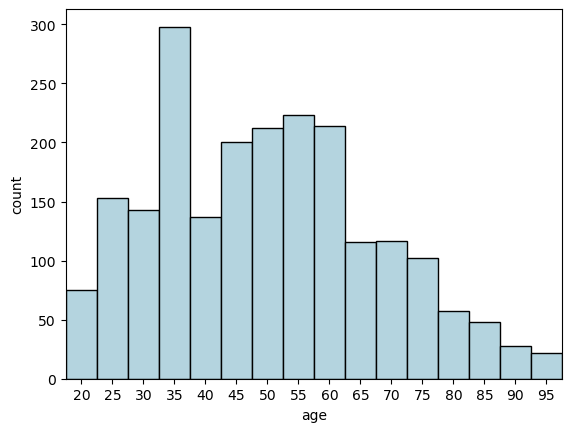

In [18]:
fraud = rdf.filter(pl.col("is_fraud") == True)
not_fraud = rdf.filter(pl.col("is_fraud") == False)

fraud.histplot(x="age", bins=5)

This shows us that clients between the ages of 30 and 55 are the most frequent victims of fraud. However, we may want to look at this in context by mapping out the likelihood of a transaction being fraudulent relative to an age group's total transactions.

To do this, we will first create a new column `age range` with ages rounded down to the nearest multiple of 5. We could do this manually, but we can also use an existing tool from `BastionLab`, the `ApplyBins`torch module in combination with the `apply_udf` method, which applies the `forward` function of torch modules to specified columns.

We then can use the barplot function to plot the `mean` value of `is_fraud` where values closer to `1` represent a higher ratio of fraudulent transactions.

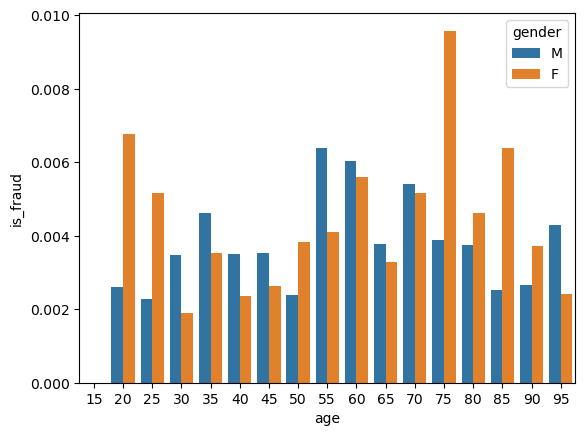

In [19]:
# import ApplyBins module
from bastionlab.polars.utils import ApplyBins

# instantiate ApplyBins with a bins_value of 5
model = ApplyBins(5)

# select columns and apply bins to "age" column
age_comp = rdf.select([pl.col("age"), pl.col("gender"), pl.col("is_fraud")]).apply_udf(
    ["age"], model
)

# get barplot visualization
age_comp.barplot(x="age", y="is_fraud", hue="gender")

This paints a very different picture. We see that women aged 75-80 are particularly at risk of being the victim of fraud.

Let's finally get a list of the most at-risk age category across all genders.

We will do this by grouping data by `age` (with the bins from the previous query applied) and creating two columns, `total` and `fraud`. Total is a `count` of all `is_fraud` values per each group, regardless of if they are True of False, whereas `fraud` is the sum of the `is_fraud` values, so `False` values which equal 0 will not be part of the sum.

Next we create a `percentage` column, and finally we select the `age` and `percentage` columns only and `fetch` this table in descending order.

In [20]:
percentage = age_comp.groupby("age").agg(
    [pl.col("is_fraud").sum().alias("fraud"), pl.col("is_fraud").count().alias("total")]
)

percentage = percentage.with_column(
    (pl.col("fraud") / pl.col("total") * 100).alias("percentage")
)
percentage.select([pl.col("age"), pl.col("percentage")]).sort(
    pl.col("percentage"), reverse=True
).collect().fetch()

age,percentage
i32,f64
75,0.608193
60,0.579836
55,0.536354
70,0.525512
85,0.484408
20,0.442035
80,0.423603
35,0.394441
25,0.388799


### Focus on time and date

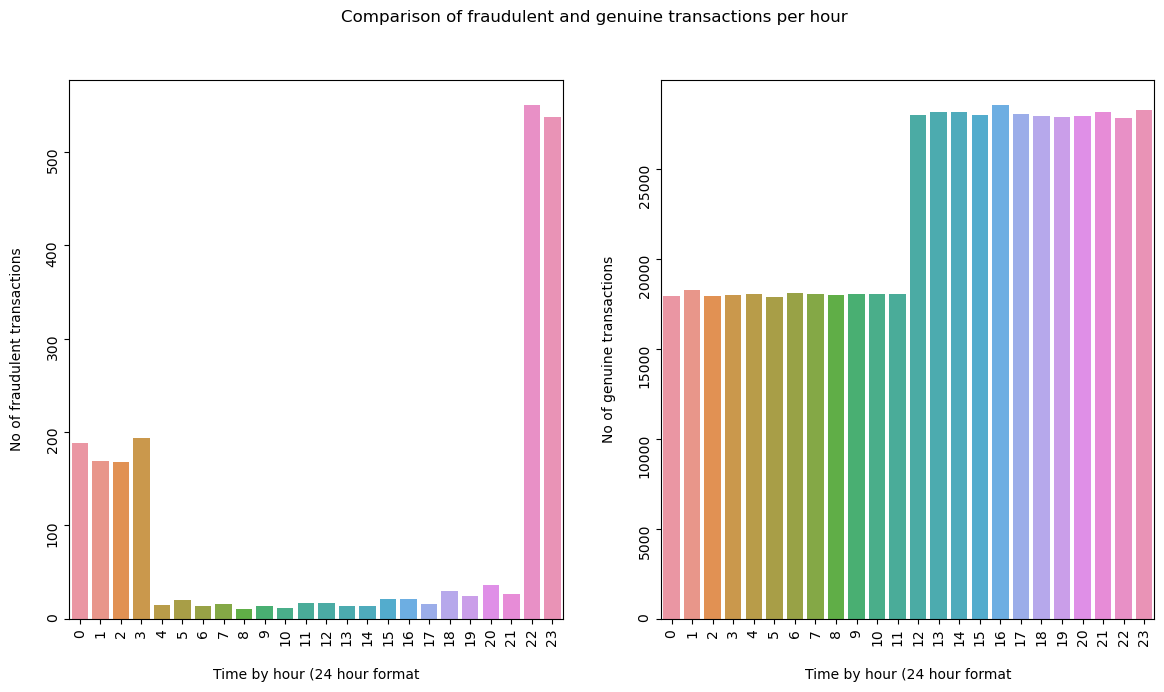

In [65]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

time = (
    fraud.groupby(pl.col("trans_time").dt.hour())
    .agg(pl.count())
    .sort(pl.col("trans_time"))
)

time.barplot(x="trans_time", y="count", ax=ax1)
plt.xticks(
    rotation=90,
)

time = (
    not_fraud.groupby(pl.col("trans_time").dt.hour())
    .agg(pl.count())
    .sort(pl.col("trans_time"))
)

time.barplot(x="trans_time", y="count", ax=ax2)
ax1.set_ylabel("No of fraudulent transactions\n")
ax1.set_xlabel("\nTime by hour (24 hour format")
fig.suptitle("Comparison of fraudulent and genuine transactions per hour")
ax2.set_ylabel("No of genuine transactions\n")
ax2.set_xlabel("\nTime by hour (24 hour format")

# set x axis labels and totates X-Axis labels by 90 degrees
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)

plt.show()

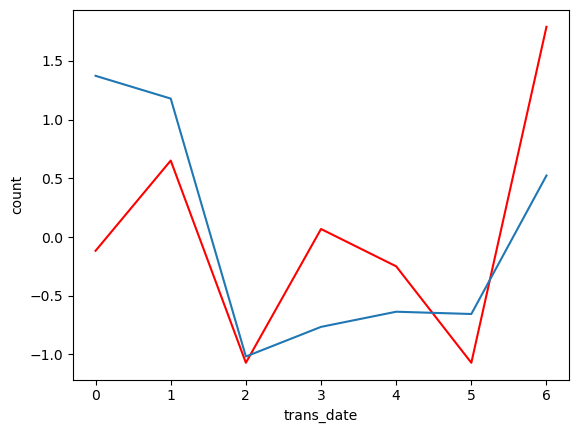

In [63]:
time = (
    fraud.groupby(pl.col("trans_date").dt.weekday())
    .agg(pl.count())
    .sort(pl.col("trans_date"))
)

time = time.zscore_scale("count")
time.lineplot(x="trans_date", y="count", color="red")

time = (
    not_fraud.groupby(pl.col("trans_date").dt.weekday())
    .agg(pl.count())
    .sort(pl.col("trans_date"))
)
time = time.zscore_scale("count")
time.lineplot(x="trans_date", y="count")


plt.show()

### Focus on catgeory

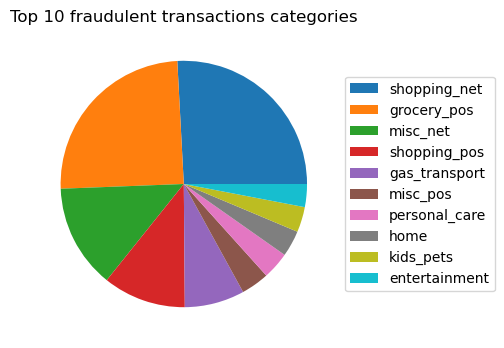

In [25]:
fraud_per_cat = (
    fraud.groupby(pl.col("category"))
    .agg(pl.count())
    .sort(pl.col("count"), reverse=True)
    .limit(10)
)
fraud_per_cat.collect().fetch()

fraud_per_cat.pieplot(
    labels="category",
    parts="count",
    title="Top 10 fraudulent transactions categories",
    pie_labels=False,
)

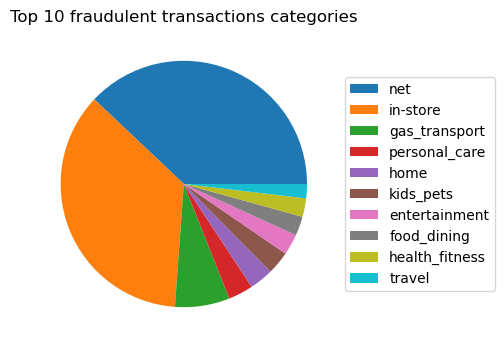

In [69]:
cat = fraud.with_column(
    pl.when(pl.col("category").str.ends_with("net"))
    .then("net")
    .when(pl.col("category").str.ends_with("pos"))
    .then("in-store")
    .otherwise(pl.col("category"))
    .alias("category")
).collect()

fraud_per_cat = (
    cat.groupby(pl.col("category"))
    .agg(pl.count())
    .sort(pl.col("count"), reverse=True)
    .limit(10)
)
fraud_per_cat.collect().fetch()

fraud_per_cat.pieplot(
    labels="category",
    parts="count",
    title="Top 10 fraudulent transactions categories",
    pie_labels=False,
)

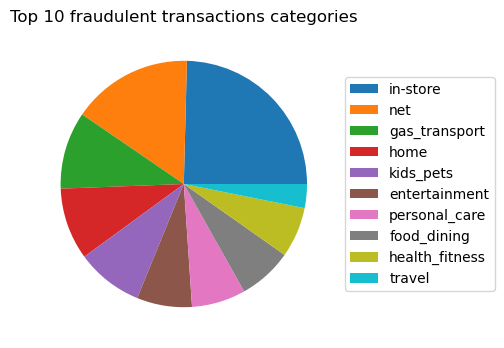

In [70]:
cat = not_fraud.with_column(
    pl.when(pl.col("category").str.ends_with("net"))
    .then("net")
    .when(pl.col("category").str.ends_with("pos"))
    .then("in-store")
    .otherwise(pl.col("category"))
    .alias("category")
).collect()

fraud_per_cat = (
    cat.groupby(pl.col("category"))
    .agg(pl.count())
    .sort(pl.col("count"), reverse=True)
    .limit(10)
)
fraud_per_cat.collect().fetch()

fraud_per_cat.pieplot(
    labels="category",
    parts="count",
    title="Top 10 fraudulent transactions categories",
    pie_labels=False,
)

### Conclusions

So far our data scientist has been able to gain some interesting insights from our dataset: 30-40 year olds are the most frequent victims of fraudulent bank transactions, fraudulent transactions tend to happen in the evening, especially between 10pm and midnight, the amounts are most frequently small amounts, particularly transactions of £0-50.

Once we are happy with what we have discovered we can close our connection to the server and stop the server:

In [27]:
# connection.close()
# bastionlab_server.stop(srv)